In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import time
import copy

In [2]:
# define the image transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Data load
trainset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=data_transforms['train'])
valset = datasets.CIFAR10(root='./CIFAR10', train=False,download=True, transform=data_transforms['val'])

trainloader = DataLoader(trainset, batch_size = 32, shuffle = True, num_workers=0)
valloader = DataLoader(valset, batch_size = 32,shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataloaders = {'train':trainloader, 'val':valloader}
dataset_sizes = {'train':len(trainset), 'val':len(valset)}

In [4]:
dataset_sizes

{'train': 50000, 'val': 10000}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

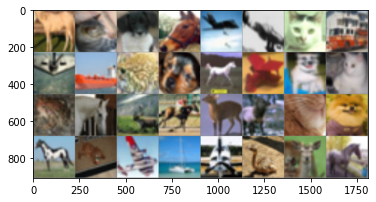

horse   cat   dog horse plane plane   cat truck plane  ship  frog   dog horse plane   dog   cat  frog horse  deer horse  deer  deer   cat   dog horse   dog plane  ship plane  bird  deer horse


In [31]:
class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % class_names[labels[j]] for j in range(32)))

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10).cuda()

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # dataloader로부터 dataset과 그에 해당되는 label을 불러온다.
            for inputs, labels in dataloaders[phase]:  
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림
                # zero the parameter gradients
                optimizer.zero_grad()  #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).cuda()
                    _, preds = torch.max(outputs, 1) # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels).cuda()

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        preds=preds.cpu()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.cuda()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


print('================Finished modeling')

================Finished modeling


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10).cuda()
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------


C:\Miniconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8902 Acc: 0.7022
val Loss: 0.7321 Acc: 0.7504

Epoch 1/1
----------
train Loss: 0.7180 Acc: 0.7514
val Loss: 0.7637 Acc: 0.7406

Training complete in 3m 38s
Best val Acc: 0.750400


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = models.mobilenet_v2(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 10).cuda()
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 0.9433 Acc: 0.6730
val Loss: 1.1516 Acc: 0.6014

Epoch 1/1
----------
train Loss: 0.8302 Acc: 0.7104
val Loss: 1.1801 Acc: 0.6126

Training complete in 3m 60s
Best val Acc: 0.612600


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.mobilenet_v2(pretrained=True) 
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 10).cuda()

model_ft = model_ft.to(device) #fine tuning

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = StepLR(optimizer_ft, step_size=4, gamma=0.1)

In [21]:
model_finetuning_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.6722 Acc: 0.7703
val Loss: 0.5018 Acc: 0.8284

Epoch 1/7
----------
train Loss: 0.4576 Acc: 0.8438
val Loss: 0.4329 Acc: 0.8572

Epoch 2/7
----------
train Loss: 0.3826 Acc: 0.8692
val Loss: 0.4110 Acc: 0.8631

Epoch 3/7
----------
train Loss: 0.3349 Acc: 0.8858
val Loss: 0.4010 Acc: 0.8663

Epoch 4/7
----------
train Loss: 0.1537 Acc: 0.9475
val Loss: 0.2528 Acc: 0.9161

Epoch 5/7
----------
train Loss: 0.0983 Acc: 0.9665
val Loss: 0.2515 Acc: 0.9213

Epoch 6/7
----------
train Loss: 0.0679 Acc: 0.9774
val Loss: 0.2691 Acc: 0.9187

Epoch 7/7
----------
train Loss: 0.0508 Acc: 0.9832
val Loss: 0.2788 Acc: 0.9209

Training complete in 35m 56s
Best val Acc: 0.921300


In [28]:
from torch.autograd import Variable

class_names = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

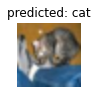

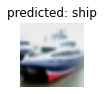

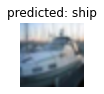

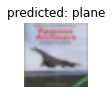

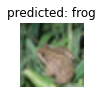

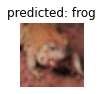

In [32]:
visualize_model(model_ft)